In [1]:
import pandas as pd
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
metadata_path = '../../../../../metadata/MBC/timepoint_data.txt'
ID_path = '../../../../../metadata/MBC/pyclone_clusters/cropped_ids.txt'
pyclone_path = '../../../../../metadata/MBC/pyclone_clusters/pyclone_output_tables/'

In [3]:
#import timepoint data
timepoint_data = pd.read_csv(metadata_path, sep='\t')

timepoint_data = timepoint_data[~(timepoint_data['met_to_processing_months'].isnull())] 

#import predictions
feature_type = 'ATAC'
in_dir = feature_type+'_results/'
predictions = pd.read_csv(in_dir+'per_sample_means.txt',sep='\t')
predictions = predictions[predictions['tumor_fraction']>=0.05]
predictions['merged_TimeFromMet_ToDeathOrLastFU_Months'] = predictions['merged_TimeFromMet_ToDeathOrLastFU_Days']/30

merged = predictions.merge(timepoint_data[['sample','met_to_processing_months']], on = 'sample')
                    
print(len(merged)) #should be 30

#import sample ID matches
IDs = pd.read_csv(ID_path,sep='\t')
pairs = IDs[['PatientID','submitted_subject_id']].drop_duplicates()

30


In [4]:
timepoint_data = timepoint_data[['patient_id','cfDNA_tube','met_to_processing_months','tumor_fraction']]

In [5]:
timepoint_data.head()

,patient_id,cfDNA_tube,met_to_processing_months,tumor_fraction
0,MBC_1413,FC15883183,9.300000,0.07401
1,MBC_1413,FC16207807,10.000000,0.12290
2,MBC_1413,FC15883184,11.433333,0.17340
3,MBC_1413,FC15883182,7.900000,0.02966
4,MBC_1413,FC16207805,6.533333,0.31460


In [6]:
merged.head()

,sample,median_probability,median_prediction,patient_id,TNBC_ULPWGS_ID,PatientID_09204,PatientID_05246,tumor_fraction,ulp_wgs_coverage,merged_PrimaryEstrogenStatus,...,merged_updated_ER_status,merged_updated_ER_status_binary,merged_PrimaryProgesteroneStatus,merged_MetsProgesteroneStatus,merged_PR_switch,merged_TimeFromMet_ToDeathOrLastFU_Days,merged_DeathCensor,first_passing_sample,merged_TimeFromMet_ToDeathOrLastFU_Months,met_to_processing_months
0,MBC_1306_2_ULP,0.559576,1,MBC_1306,TNBC_ULPWGS_28,09204_527,NaN,0.1369,0.101848,-,...,-,-,-,-,same,827.0,1.0,NaN,27.566667,21.700000
1,MBC_1306_3_ULP,0.132673,0,MBC_1306,TNBC_ULPWGS_28,09204_527,NaN,0.2397,0.140306,-,...,-,-,-,-,same,827.0,1.0,NaN,27.566667,19.600000
2,MBC_1306_4_ULP,0.166257,0,MBC_1306,TNBC_ULPWGS_28,09204_527,NaN,0.1217,0.139495,-,...,-,-,-,-,same,827.0,1.0,NaN,27.566667,20.300000
3,MBC_1306_6_ULP,0.193538,0,MBC_1306,TNBC_ULPWGS_28,09204_527,NaN,0.3060,0.130952,-,...,-,-,-,-,same,827.0,1.0,1.0,27.566667,18.133333
4,MBC_1306_7_ULP,0.251019,0,MBC_1306,TNBC_ULPWGS_28,09204_527,NaN,0.3130,0.132264,-,...,-,-,-,-,same,827.0,1.0,NaN,27.566667,23.333333


RP-527 MBC_1306
5
same
3.875 3.0199999999999996


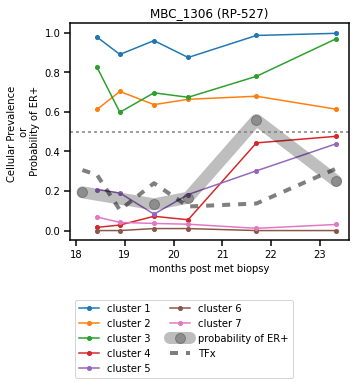




RP-557 MBC_1308
4
same
3.875 3.0199999999999996


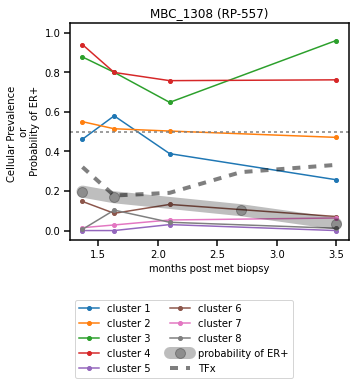




RP-639 MBC_1322
4
same
3.875 3.0199999999999996


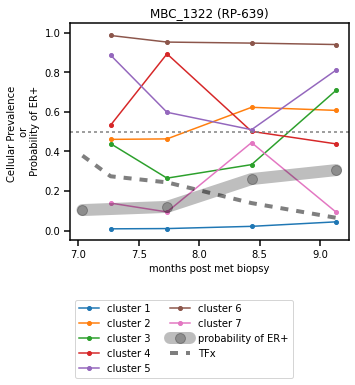




RP-608 MBC_1405
5
same
3.875 3.0199999999999996


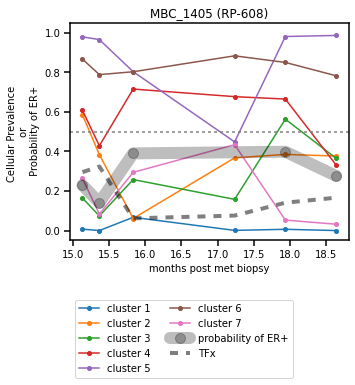




RP-535 MBC_1406
6
unknown
3.875 3.0199999999999996


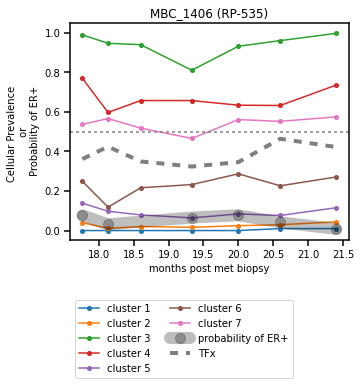




RP-526 MBC_1413
6
loss
3.875 3.0199999999999996


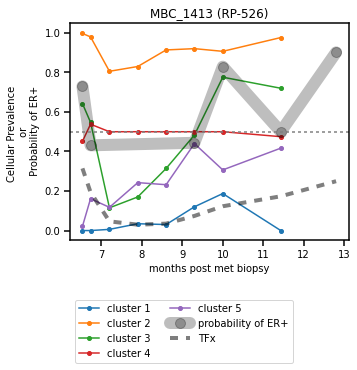

In [7]:
for i in range(len(pairs)):
    RP_ID = pairs.iloc[i]['PatientID']
    MBC_ID = pairs.iloc[i]['submitted_subject_id']
    
    #1302 was not included due to missing ER status
    if MBC_ID == 'MBC_1302':
        continue
        
    print(RP_ID,MBC_ID)
    
    #double the axis thickness and ticks so I can shrink the plot
    plt.rc('axes', linewidth=1.5)
    fig,ax = plt.subplots(figsize = (5,4)) #4.5,6 for square version
    
    #double the axis thickness and ticks so I can shrink the plot
    ax.tick_params(length=6, width=1.5)
    
    current = merged[merged['patient_id']==MBC_ID].sort_values(by='met_to_processing_months')
    print(len(current))
    if len(current)>0:
        print(current['merged_ER_switch'].values[0])
  
    data = pd.read_csv(pyclone_path+RP_ID+'-joint-cluster.tsv',sep='\t')
    data = data.merge(timepoint_data[['cfDNA_tube','met_to_processing_months']], left_on = 'sample_id', right_on = 'cfDNA_tube')

    for ID,df in data.groupby('cluster_id'):
        df = df.sort_values(by = 'met_to_processing_months')
        ax.plot(df['met_to_processing_months'],df['mean'], marker = 'o',markersize = 4, label = 'cluster '+str(ID))


    #plot the predictions and tumor fraction
    ax.plot(current['met_to_processing_months'], current['median_probability'], marker = 'o', markersize = 10, alpha = 0.255, linewidth = 12,color='black', solid_capstyle = 'round', label = 'probability of ER+')    
    
    #plot the tumor fraction
    tfx_data = timepoint_data[timepoint_data['patient_id']==MBC_ID].sort_values(by='met_to_processing_months')
    ax.plot(tfx_data['met_to_processing_months'], tfx_data['tumor_fraction'], color='black', alpha = 0.5, linewidth = 4, dashes=[2,2],label = 'TFx')    
    
    
    ax.axhline(0.5,color = 'grey', dashes = [2,2])
    ax.set_ylim(-0.05,1.05)
    ax.set_ylabel('Fraction')
    ax.set_xlabel('months post met biopsy')    
    
    
    ax.set_ylabel('Cellular Prevalence \n or \n Probability of ER+')
    ax.set_title(MBC_ID + ' (' + RP_ID + ')')
    
            
    ax.legend(bbox_to_anchor=[0,-.25], loc = 'upper left', ncol= 2) 
    
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    print(width,height)
    
    plt.savefig(in_dir+'pyclone/'+MBC_ID+'.pdf')
    
    #save a square shaped version for the supplement
    #not working, wrong fig size
    #ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    #fig.subplots_adjust(top = 1.25,left = .23)
    #plt.savefig(in_dir+'pyclone/'+MBC_ID+'_square.pdf')

    plt.show()
    print('\n\n')
    
